Edward Nunez
Prof. Zhou
Assignment 5 

In this assignment we apply machine learning techniques to attempt to classify images of skin lesions to their respective disease category. The images are provided by the HAM10000 Dataset. 

To make sure you can run this file, the data must unzipped and be in the following subdirectory respective to the location of this file: /data/lesions/

Run a

In [1]:
#Imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch as tor
import torchvision as tcv
import pandas as pd
import imageio
import seaborn as sns
import glob2
import scipy

from PIL import Image
import os
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from keras.models import Sequential 
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

2022-03-25 00:28:51.471193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-25 00:28:51.471299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Import the meta data file for analysis and exploration 
df = pd.read_csv('data/lesions/HAM10000_metadata')

In the following cell we explore the data visually by plotting the distribution of a few of the dataset features. The most important of these is dx, which is the disease category, the class feature of our dataset. In that plot we can see that dataset is totally unbalanced. The vast majority of the entries fall under the nv or Melanocytic Nevus class. We will have to make an effort to balance the dataset before we define and train our model.

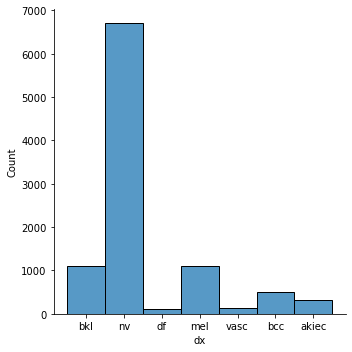

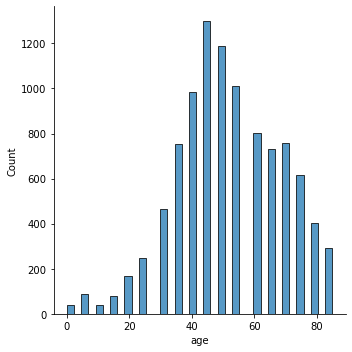

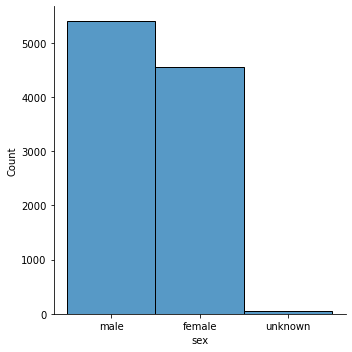

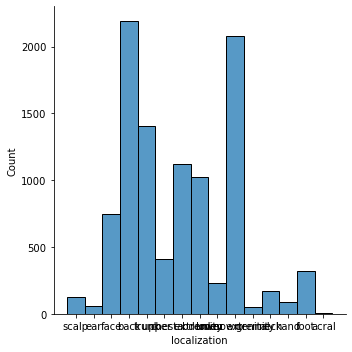

In [3]:
sns.displot(df.dx)
sns.displot(df.age)
sns.displot(df.sex)
sns.displot(df.localization)

In the next cell the dataset is made balanced. The method is to resample -- essentially create a new dataset with uniform distribution of entries across classes by picking entries from each class at random with replacement until a set number of entries is reached. The number is set to be 1000 which is just a fraction of the actual dataset but it would not be wise to go much higher because certain classes have very few entries. 

In [4]:
#Add a label feature to translate the class labels from strings to into integers. 
le = LabelEncoder()
le.fit(df['dx'])
df['label'] = le.transform(df["dx"])

#Separate the dataset by label
df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1]
df_2 = df[df['label'] == 2]
df_3 = df[df['label'] == 3]
df_4 = df[df['label'] == 4]
df_5 = df[df['label'] == 5]
df_6 = df[df['label'] == 6]

#Resample the separate datasets
#Setting a random state value allows reproducibility of the same results 
n_samples = 1000 
df_0_balanced = resample(df_0, replace = True, n_samples = n_samples, random_state = 1) 
df_1_balanced = resample(df_1, replace = True, n_samples = n_samples, random_state = 1) 
df_2_balanced = resample(df_2, replace = True, n_samples = n_samples, random_state = 1)
df_3_balanced = resample(df_3, replace = True, n_samples = n_samples, random_state = 1)
df_4_balanced = resample(df_4, replace = True, n_samples = n_samples, random_state = 1)
df_5_balanced = resample(df_5, replace = True, n_samples = n_samples, random_state = 1)
df_6_balanced = resample(df_6, replace = True, n_samples = n_samples, random_state = 1)

#Join the resampled separate datasets into one balanced dataset
df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In the next cell the images are now pulled into memory. First the path of entry is added to the dataset, then the path is used to read and resize the image as a 32x32 array of pixels which are each represented by three bytes or three integers in the range 0 to 255.

In [5]:
image_path = {os.path.splitext(os.path.basename(x))[0]: 
                     x for x in glob(os.path.join('data/lesions', 'HAM10000*', '*.jpg'))}

df_balanced['path'] = df['image_id'].map(image_path.get)

size = 32
df_balanced['image'] = df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((size,size))))

In the next cell the data is split into test and train sets. 
X is the feature set. The only feature we care about is the image column. Dividing by 255.0 scales all X values from 0 to 1. 
Y is the label set. Using the to_categorical method we convert the labels to one hot encoding form.
The test size is selected to be 25%.

In [11]:
X = np.asarray(df_balanced['image'].tolist()) / 255.0
Y = to_categorical(df_balanced['label'], num_classes = 7) 

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 1)

In the next cell a model is defined. 

I had the hardest time here. I have yet to fully understand how to build a competent model using the Keras framework but I have managed to build a working model. It is a simple sequential model with three layers: convolutional with relu activation, flatten, and dense with softmax activation. The loss function is categorical crossentropy. More research into this library will be the focus for the next assignment. 

In [59]:
size = 32
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(size, size, 3)))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 flatten_13 (Flatten)        (None, 230400)            0         
                                                                 
 dense_36 (Dense)            (None, 7)                 1612807   
                                                                 
Total params: 1,619,975
Trainable params: 1,619,975
Non-trainable params: 0
_________________________________________________________________


Finally the model is run. The batch size is the number of samples for each iteration that the model is fed. An epoch is an entire pass over the entire dataset. 

In [60]:
batch_size = 100 
epochs = 20

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/20
53/53 - 11s - loss: 2.3227 - acc: 0.2857 - val_loss: 1.5823 - val_acc: 0.3789 - 11s/epoch - 206ms/step
Epoch 2/20
53/53 - 11s - loss: 1.4471 - acc: 0.4552 - val_loss: 1.3518 - val_acc: 0.5006 - 11s/epoch - 204ms/step
Epoch 3/20
53/53 - 10s - loss: 1.2642 - acc: 0.5331 - val_loss: 1.2513 - val_acc: 0.5440 - 10s/epoch - 192ms/step
Epoch 4/20
53/53 - 10s - loss: 1.1612 - acc: 0.5832 - val_loss: 1.2303 - val_acc: 0.5389 - 10s/epoch - 185ms/step
Epoch 5/20
53/53 - 10s - loss: 1.0898 - acc: 0.6069 - val_loss: 1.1129 - val_acc: 0.6171 - 10s/epoch - 184ms/step
Epoch 6/20
53/53 - 10s - loss: 1.0169 - acc: 0.6402 - val_loss: 1.0730 - val_acc: 0.6274 - 10s/epoch - 192ms/step
Epoch 7/20
53/53 - 10s - loss: 0.9608 - acc: 0.6669 - val_loss: 1.0263 - val_acc: 0.6646 - 10s/epoch - 184ms/step
Epoch 8/20
53/53 - 11s - loss: 0.9168 - acc: 0.6800 - val_loss: 0.9570 - val_acc: 0.6760 - 11s/epoch - 208ms/step
Epoch 9/20
53/53 - 10s - loss: 0.8601 - acc: 0.7088 - val_loss: 0.9581 - val_acc: 0.6680

The final accuracy of the model is .78 which being significantly over .50 is quite good. However it is important to recall how poorly the dataset was imbalanced and how many duplicate data entries are involved in the final training dataset. 

In [62]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

55/55 [==============================] - 1s 12ms/step - loss: 0.6632 - acc: 0.7817
Test accuracy: 0.7817142605781555


Some of the many resources used in this assignment:

https://keras.io/api/layers/reshaping_layers/flatten/
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
https://www.activestate.com/resources/quick-reads/what-is-a-keras-model/
http://man.hubwiz.com/docset/Keras.docset/Contents/Resources/Documents/getting-started/sequential-model-guide.html
https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
https://faroit.com/keras-docs/1.0.1/getting-started/sequential-model-guide/
https://pythonbasics.org/split-train-test/